<a href="https://colab.research.google.com/github/times2049/Diffusion-Models-from-scratch-in-Pytorch-for-edu/blob/main/Diffusion_Models_from_scratch_in_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#cross-attention 나중에

In [ ]:
class CrossAttention(nn.Module):
    def __init__(self, dim_eps, dim_tau, heads=8, dim_head=64, dropout=0.,i=None):
        super().__init__()
        dim = dim_head * heads
        W = lambda d: nn.Linear(d, dim, bias=False)
        self.W_q, self.W_k, self.W_v = map(W, (dim_eps, dim_tau, dim_tau))
        #???????이건 왜 없는데
        self.W_out = nn.Linear(dim, dim_eps)
        self.heads = heads
        self.dim_head = dim_head 
        self.scale = dim_head ** -0.5
        
    def forward(self, phi_i_zt, tau_theta_y):
        # phi_i_zt (B, N, dim_eps)
        # tau_theta_y (B, M, dim_tau) ;context;  from a domain specific encoder that projects y
        # W_q: (B, dim_eps, dim)    
        #W_k, W_v:  (B, dim_tau, dim)
        q, k, v = self.W_q(phi_i_zt), self.W_k(tau_theta_y), self.W_v(tau_theta_y)
        # q: (B, N, dim),   k, v: (B, M, dim)
        # (h d) = dim
        h = self.heads
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h=h), (q, k, v))
        # q: (B*h, N, dim/h),   k, v: (B*h, M, dim/h)

        similarity = einsum('b i d, b j d -> b i j', q, k) * self.scale
        # similarity: (B*h, N, M)

        # attention, what we cannot get enough of
        attn_dist = similarity.softmax(dim=-1)
        # attn_dist: (B*h, N, M), v (B*h, M, d)
        out = einsum('b i j, b j d -> b i d', attn_dist, v) 
        # out: (B*h, N, d)
        out = rearrange(out, '(b h) n d -> b n (h d)', h=h)
        # out: (B, N, h*d)

        return self.W_out(out)

In [ ]:
"""
def make_variance_schedule(how_to="cosine", T, cos_s=??):
    if how_to == "cosine":
        timesteps = (arange(T + 1) / T + cos_s) #arange: (0,....,T)
        alphas = timesteps / (1 + cos_s) * pi / 2
        alphas = cos(alphas).pow(2)
        alphas = alphas / alphas[0]
        betas = 1 - alphas[1:] / alphas[:-1]
        betas = clip(betas, a_min=0, a_max=0.999) # a_max?
    return betas
        """

# forward diffusion process

#beta schedule

In [3]:
from torch import linspace
def make_beta_schedule(how_to, T, start=1e-4, end=2e-2): #todo 다시보자
  """
  beta_t = a variance of Gaussin noise in t step
  설명, 인자도 설명
  어키어키
  """
  if how_to == "linear":
    betas = (linspace(start, end, T)) #(1e-4, ... , 2e-2)
  return betas

In [4]:
IMG_SIZE, BATCH_SIZE = 64, 128

In [5]:
T = 100 # Total steps
betas = make_beta_schedule('linear', T)

In [6]:
def get_index_from_list(vals, t, x_shape): #todo이거 왜있는건데? 저장해놓든가
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [23]:
from torch import cumprod, sqrt, randn_like

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = cumprod(alphas, axis=0)
# calculations for diffusion q(x_t | x_{t-1}) and others
coef_X0, coef_noise = sqrt(alphas_cumprod), sqrt(1 - alphas_cumprod) 
X0_shape = X0.shape


In [10]:
def diffuse(X0, t):
  noise = randn_like(X0)# N(0,I)
  coef_X0_t = get_index_from_list(coef_X0, t,X0.shape)#todo shape에서 반복계산 좀 없게
  coef_noise_t = get_index_from_list(coef_noise, t, X0.shape)
  Xt = coef_X0_t * X0 + coef_noise_t * noise #reparameterization trick
  return Xt, noise

In [15]:
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import StanfordCars
import numpy as np
from torchvision.transforms import Resize, RandomHorizontalFlip \
                                    ,ToTensor, Lambda, Compose

IMG_SIZE = 64
BATCH_SIZE = 128

def load_dataset(): #todo transfrom 함수 따로
    data_transforms = [
                        Resize((IMG_SIZE, IMG_SIZE)), #todo:하나만 넣어도 될텐데? 확인
                        RandomHorizontalFlip(),
                        ToTensor(), # Scales data into [0,1] 
                        Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
                    ]
    data_transform = Compose(data_transforms)
     #todo 데이터 바꾸기
    train = StanfordCars(root=".", download=True, 
                                         transform=data_transform)

    test = StanfordCars(root=".", download=True, 
                                         transform=data_transform, split='test')
    return ConcatDataset([train, test])



In [17]:
datasets = load_dataset()
dataloader = DataLoader(datasets, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

  0%|          | 0/330960 [00:00<?, ?it/s]

Extracting stanford_cars/car_devkit.tgz to stanford_cars


  0%|          | 0/979269282 [00:00<?, ?it/s]

Extracting stanford_cars/cars_train.tgz to stanford_cars
Using downloaded and verified file: stanford_cars/car_devkit.tgz
Extracting stanford_cars/car_devkit.tgz to stanford_cars


  0%|          | 0/977350468 [00:00<?, ?it/s]

Extracting stanford_cars/cars_test.tgz to stanford_cars


  0%|          | 0/185758 [00:00<?, ?it/s]

In [40]:
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import numpy as np
def ScaleBack():
  def scale_back(X):
    X += 1
    X /= 2
    X = X.permute(1,2,0) # CHW to HWC
    X *= 255.
    return X.numpy().astype(np.uint8) #todo 깔끔하지 못하다.
  return Lambda(scale_back)

def show_image(image):
    reverse_transforms = Compose([ #todo : 람다 한꺼번에 묶어서 함수로
                                  ScaleBack(),
                                  ToPILImage()
                              ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))



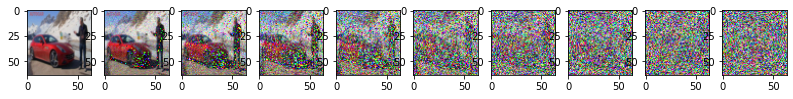

In [41]:
from torch import Tensor, int64

plt.figure(figsize=(15,15)) # todo 이런것도 좀 깔끔하게 안되나.
plt.axis('off')
num_images = 10
stepsize = int(T/num_images) #노이즈 횟수
X0, _ = next(iter(dataloader)) # 확인 해보자
for t in range(0, T, stepsize):
  t = Tensor([t]).type(int64)
  plt.subplot(1, num_images+1, (t/stepsize) + 1)
  Xt, _ = diffuse(X0, t)
  # todo:이미지 출력
  show_image(Xt)

In [43]:
from torch.nn import Conv2d, ReLU, BatchNorm2d, Linear, ConvTranspose2d, Module
from torch.nn.functional import relu
class ConvActNorm(Module):
    def __init__(self, in_ch, out_ch):
      super().__init__()
      self.conv = Conv2d(in_ch , out_ch, fs=3)
      self.act = ReLU()
      self.norm = BatchNorm2d(out_ch)
    def forward(self,x):
      return self.norm(relu(self.conv(x)))

class Block(Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, is_up=None):
        super().__init__()
        self.mlp = Linear(time_emb_dim, out_ch)
        if is_up:
          in_ch = 2* in_ch
          Interpolate2d = ConvTranspose2d
        else:
          Interpolate2d = Conv2d #todo 줄 너무 길다!!
        self.CAN1, self.CAN2 = ConvActNorm(in_ch, out_ch), ConvActNorm(out_ch, out_ch)
        self.Down_or_Up = Interpolate2d(out_ch, out_ch, 4, 2, 1)

    def forward(self, x, t):
        time_embedding = relu(self.mlp(t))
        h = self.CAN1(x)
        h += time_embedding[ (..., ) + (None, None) ] # for 무슨 그 casting
        h = self.CAN2(h)
        return self.Down_or_Up(h)

In [ ]:
from torch import cat, exp
class SinusoidalPositionEmbeddings(Module):   # todo 이건 또 개념부터 설명해야
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1) #todo 이런거 계산 깔끔하게 하고싶다
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings

In [44]:
from torch.nn import ModuleList

class Unet(Module):
    def __init__(self, chs = (64, 128, 256, 512), time_emb_dim = 32):
        super().__init__()
        img_ch = 3
        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                Linear(time_emb_dim, time_emb_dim)
            )
        # Initial projection
        self.init = Conv2d(img_ch, chs[0], filter_size=3, pad=1) #todo  filter size
        # Downsample
        self.downs = ModuleList([Block(chs[i], chs[i+1], \
                                    time_emb_dim, is_up=False) \
                    for i in range(len(chs)-1)])
        # Upsample
        self.ups = ModuleList([Block(chs[i], chs[i+1], \
                                        time_emb_dim, is_up=True) \
                    for i in reversed(range(len(chs)-1))])

        self.out = Conv2d(chs[0], img_ch, fs=1)

    def forward(self, x, t):
        x, t, residuals = self.init(x), relu(self.time_mlp(t)), []
        # Unet
        for down in self.downs:
            x = down(x, t)
            residuals.append(x)

        for up in self.ups:
            x = cat( [x, residuals.pop()] )           
            x = up(x, t)
        return self.out(x)

In [45]:
from torch.optim import Adam

model = Unet()
optimizer = Adam(model.parameters(), lr=0.001)

NameError: ignored

In [ ]:
  """ 
  X0, t :  an image, a timestep 
  """

In [ ]:
def trainer(model, optimizer, dataloader):
  for step, (X0, _) in enumerate(dataloader):
    optimizer.zero_grad()
    t = randint(0, T, (BATCH_SIZE,))

    Xt, noise = diffuse(X0, t) # Xt : a noisy image

    predicted = model(Xt, t)

    loss = L2_loss(noise, predicted)
    
    loss.backward()
    optimizer.step()
  return loss

In [ ]:
  if epoch % 5 == 0 and step == 0:
    print(f"Epoch {epoch} | Loss: {loss.item()} ")
    sample_plot_image()

#Training

In [ ]:
epochs = 100
for epoch in range(epochs):
  loss = trainer()


In [ ]:
sqrt_recip_alphas = sqrt(1.0 / alphas)
sqrt_one_minus_alphas_cumprod = sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - cumprod_prev) / (1. - alphas_cumprod)

#Sampling

In [ ]:
def inference(T):
  Xt = XT = noise = randn_like(x) # todo 이거 x 어쩌니

  for t in range(T, 0, -1):
    Xt_prev = sample_to_inference(Xt, t) #todo 함수 이름 조금 고민하자
    Xt = Xt_prev # 알고리즘 설명을 위해
  X0_generated = sample_to_inference(Xt_prev, 0)
  #의미를 살리기 위해...
  return X0__generated # todo 이름 어떻게 할까나

X0_list = []
n = 10 # 생성 결과 몇 개 뽑고 싶은데?
for i in range(n):
  X0_list.append(inference(T))

# todo show 이미지

In [ ]:
from torch import no_grad
@no_grad()
def sample_to_inference(Xt, t): 
    """
    Calls the model 
    to predict the noise in the image and returns the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, Xt.shape)
    
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, Xt.shape
    )
    
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, Xt.shape)
    
    # Call model (current image - noise prediction)
    noise_predicted = model(Xt, t)
    diff = Xt - betas_t * noise_predicted
    model_mean = sqrt_recip_alphas_t * ( diff / sqrt_one_minus_alphas_cumprod_t)


    posterior_variance_t = get_index_from_list(posterior_variance, t, Xt.shape)
    

    if t == 0:  # 논문에도 있다
        return model_mean
    else:
        noise = randn_like(Xt) 
        return model_mean + sqrt(posterior_variance_t) * noise

@no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, i/stepsize+1)
            show_tensor_image(img.detach().cpu())
    plt.show()      